In [46]:
%matplotlib inline
import re
import sys
import matplotlib
import seaborn
import numpy
from matplotlib import pyplot as plt
from collections import defaultdict
import pandas

import evaluate
from evaluate import IntervalForest, populate_index_from_simulation
import kevlar

seaborn.set_context({'figure.figsize': (12, 6)})
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16

In [47]:
index = populate_index_from_simulation('SimulatedVariants_chr17_hg38.tsv.gz', 'chr17')

In [48]:
def compact(reader, index, delta=10):
    variants_by_class = defaultdict(list)
    calls = list()
    for varcall in reader:
        if varcall.filterstr != 'PASS':
            continue
        callclass = varcall.attribute('CALLCLASS')
        if callclass is None:
            calls.append(varcall)
        else:
            variants_by_class[callclass].append(varcall)
    
    for callclass, calllist in variants_by_class.items():
        nmatches = 0
        match = None
        for varcall in calllist:
            hits = index.query(varcall.seqid, varcall.position, delta=delta)
            if hits == set():
                continue
            else:
                nmatches += 1
                if match is None:
                    match = varcall
                    localfound = hits
        if nmatches == 0:
            calls.append(calllist[0])
        else:
            assert nmatches > 0, nmatches
            if nmatches > 1:
                print('WARNING: found', nmatches, 'matches for CALLCLASS',
                      callclass, file=sys.stderr)
            calls.append(match)
    
    return calls

In [49]:
def roc_kevlar(filename, index, delta=30):
    reader = kevlar.vcf.VCFReader(kevlar.open(filename, 'r'))
    calls = compact(reader, index, delta=delta)
    nvariants = len(index.trees['chr17'])
    correct = 0
    false = 0
    tprs = list()
    for varcall in calls:
        valid = index.query(varcall.seqid, varcall.position, delta=delta) != set()
        if valid:
            correct += 1
            continue
        tpr = correct / nvariants
        tprs.append(tpr)
        false += 1
    return tprs

In [60]:
def roc_gatk(filename, index, delta=30):
    gatkdata = pandas.read_table('GATK_calls_30x.mvf.gz', sep='\t').sort_values('CHILD_DP', ascending=False)
    nvariants = len(index.trees['chr17'])
    correct = 0
    false = 0
    tprs = list()
    for rowindex, row in gatkdata.iterrows():
        valid = index.query(row['CHROM'], row['POS'], delta=delta) != set()
        if valid:
            correct += 1
            continue
        tpr = correct / nvariants
        tprs.append(tpr)
        false += 1
    return tprs

In [51]:
reader = kevlar.vcf.VCFReader(kevlar.open('kevlar_calls_30x.vcf.gz', 'r'))
calls = compact(reader, index, delta=30)

In [52]:
nvariants = len(index.trees['chr17'])
correct = 0
false = 0
tprs = list()
for varcall in calls:
    valid = index.query(varcall.seqid, varcall.position, delta=30) != set()
    if valid:
        correct += 1
        continue
    tpr = correct / nvariants
    tprs.append(tpr)
    false += 1

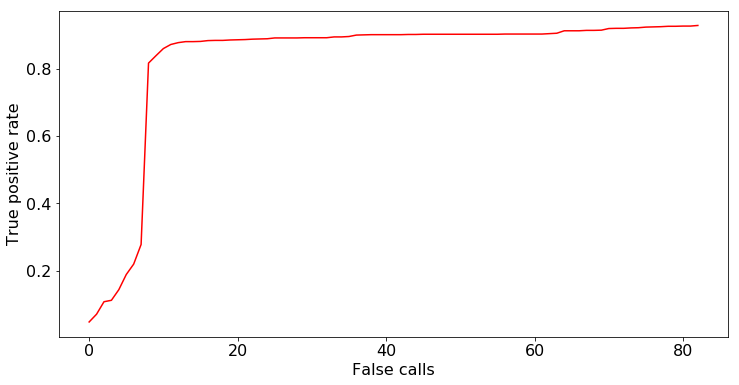

In [53]:
_ = plt.plot(range(len(tprs)), tprs, color='red')
_ = plt.xlabel('False calls')
_ = plt.ylabel('True positive rate')

In [54]:
gatk30x = pandas.read_table('GATK_calls_30x.mvf.gz', sep='\t').sort_values('CHILD_DP', ascending=False)
gatk30x.head()

,CHROM,POS,AC,FAMILY,TP,MOTHER_GT,MOTHER_DP,MOTHER_AD,MOTHER_PL,FATHER_GT,FATHER_DP,FATHER_AD,FATHER_PL,CHILD_GT,CHILD_DP,CHILD_AD,CHILD_PL
562,chr17,77821226,1,30,91.0,GGTGAGTGTCACGCAAGCATTCAATGCTCCCTAGAGGATGTGGCCA...,59,"58,1","0,172,2585",GGTGAGTGTCACGCAAGCATTCAATGCTCCCTAGAGGATGTGGCCA...,71,"71,0","0,205,3150",GGTGAGTGTCACGCAAGCATTCAATGCTCCCTAGAGGATGTGGCCA...,63,"35,28","594,0,1400"
523,chr17,72542626,1,30,80.0,CTTCCCTCCTACCGTCCAGCCCCACTTTGTCTGTGTTCCTCATCAG...,53,"53,0","0,161,2406",CTTCCCTCCTACCGTCCAGCCCCACTTTGTCTGTGTTCCTCATCAG...,68,"66,2","0,191,3068",CTTCCCTCCTACCGTCCAGCCCCACTTTGTCTGTGTTCCTCATCAG...,56,"36,20","571,0,1449"
349,chr17,51352968,1,30,28.0,AATCATGTCTCAGAGCAGCTCTGTGGGCTCGTTGTCTCAGGAGATG...,52,"52,0","0,157,2340",AATCATGTCTCAGAGCAGCTCTGTGGGCTCGTTGTCTCAGGAGATG...,36,"36,0","0,108,1589",AATCATGTCTCAGAGCAGCTCTGTGGGCTCGTTGTCTCAGGAGATG...,51,"31,20","754,0,1217"
263,chr17,40554111,1,30,54.0,CTGTTGAGAGCCTGGGAGGGCGACGCGGCAAGTGAGGGGATGAGTG...,61,"59,2","0,174,2628",CTGTTGAGAGCCTGGGAGGGCGACGCGGCAAGTGAGGGGATGAGTG...,48,"46,2","0,135,2064",CTGTTGAGAGCCTGGGAGGGCGACGCGGCAAGTGAGGGGATGAGTG...,51,"30,21","560,0,1200"
471,chr17,64966133,1,30,7.0,TTCGATTTTAGCAC/TTCGATTTTAGCAC,29,"29,0","0,87,1481",TTCGATTTTAGCAC/TTCGATTTTAGCAC,36,"36,0","0,108,1685",TTCGATTTTAGCAC/T,50,"30,20","751,0,1370"


In [55]:
nvariants = len(index.trees['chr17'])
correct = 0
false = 0
tprs = list()
for rowindex, row in gatk30x.iterrows():
    valid = index.query(row['CHROM'], row['POS'], delta=30) != set()
    if valid:
        correct += 1
        continue
    tpr = correct / nvariants
    tprs.append(tpr)
    false += 1

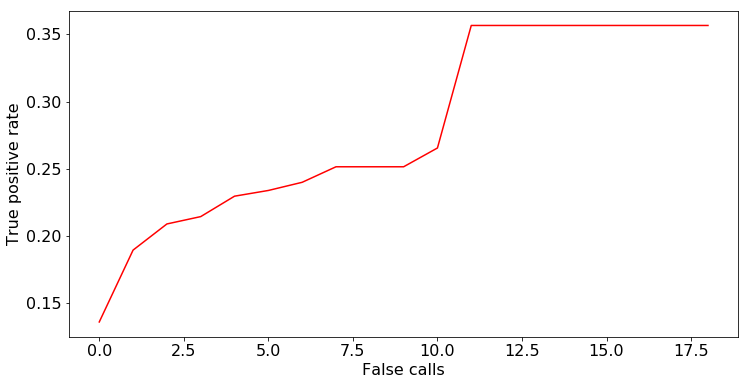

In [56]:
_ = plt.plot(range(len(tprs)), tprs, color='red')
_ = plt.xlabel('False calls')
_ = plt.ylabel('True positive rate')

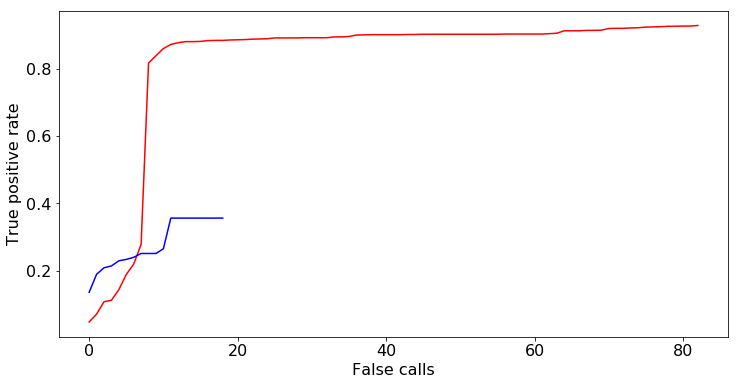

In [63]:
kevlar30x = roc_kevlar('kevlar_calls_30x.vcf.gz', index)
gatk30x = roc_gatk('GATK_calls_30x.mvf.gz', index)

_ = plt.plot(range(len(kevlar30x)), kevlar30x, color='red')
_ = plt.plot(range(len(gatk30x)), gatk30x, color='blue')
_ = plt.xlabel('False calls')
_ = plt.ylabel('True positive rate')